<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/GoldStandard1/golds_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score, mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import numpy as np

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def onehot_encode(df, columns):
    df = df.copy()
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

def preprocess_inputs(df):
    df = df.copy()
    
    # Encode label values as numbers
    df['V10'] = df['V10'].replace({'negative': 0, 'positive': 1})
    
    # One-hot encode board space columns
    df = onehot_encode(
        df,
        columns=['V' + str(i) for i in range(1, 10)]
    )
    
    # Split df into X and y
    y = df['V10'].copy()
    X = df.drop('V10', axis=1).copy()
    
    # Train-test split
   # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X, y



def evaluation_metrics(y_true, y_pred, print_result=True):
    acc = 0
    auc = 0
    auc_sk = 0
    #mi = 0
    nmi = 0
    #ami = 0
    bacc = 0
    
    # Accuracy
    #report = classification_report(y_pred.argmax(axis=1), y_true.ravel(), output_dict=True)
    acc = accuracy_score( y_true.ravel(), y_pred.argmax(axis=1))  #report['accuracy']
    
    # Balanced accuracy
    bacc = balanced_accuracy_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze(), adjusted=True)
    
   # # Mutual Information
   # mi = mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Normalized Mutual Information
    nmi = normalized_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Adjusted Mutual Information
    #ami = adjusted_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # AUC (Tensorflow)
    auc_metric = tf.keras.metrics.AUC(from_logits=True)
    auc_metric.update_state(y_true, y_pred.argmax(axis=1).astype('float'))
    auc = auc_metric.result().numpy()
    auc_metric.reset_states()
    
    # AUC (scikit-learn)
    auc_sk = roc_auc_score(ook(y_true), y_pred)
    
    if print_result:
        print("Accuracy: {:.4f}".format(acc))
        print("Balanced Accuracy: {:.4f}".format(bacc))
        print("Mutual Information: {:.4f}".format(mi))
        print("Normalized Mutual Information: {:.4f}".format(nmi))
        print("Adjusted Mutual Information: {:.4f}".format(ami))
        print("AUC (Tensorflow): {:.4f}".format(auc))
        print("AUC (scikit-learn): {:.4f}".format(auc_sk))
    
    return acc, auc, auc_sk, nmi, bacc   # mi, , ami




# Subclassing for GCCE

In [17]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1, neurons=4):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q
        self.neurons = neurons

    
 
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):

        def scheduler1(step = 10, ratio = 1.2):
          def scheduler(epoch, lr):
            if epoch % step == 0 and epoch>1:
              return lr/ratio
            else:
              return lr
          return scheduler
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        initializer = tf.keras.initializers.GlorotNormal(seed=100)

        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X.shape[1]), name='entrada')
        #capas densas
        h1 = tf.keras.layers.Dense(int(200),activation='selu',name='h1',bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
        h2 = tf.keras.layers.Dense(int(50),activation='selu',name='h2', bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
        #capa de salida
        output = tf.keras.layers.Dense(self.K,activation="softmax",name='output', bias_initializer='zeros', kernel_initializer=initializer,
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt,metrics="accuracy")
         
        callback1 = tf.keras.callbacks.TerminateOnNaN()
        callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = 1))
        #callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
        callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                                 patience=15, verbose=0, mode="auto",
                                                 baseline=None, restore_best_weights=True)
               
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split, callbacks = [callback1, callback2],   #
                                      batch_size=self.batch_size,verbose=self.verbose)
 
        return self
 
  
   
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q, 'neurons': self.neurons
                }

  
        return self


# Load Data

In [18]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np

database = 'Fashion_Mnist'
 

In [19]:
(X, t), _ =  tf.keras.datasets.fashion_mnist.load_data() 
t=t+1
X = X.reshape(len(X),-1)

# Labels Generation - 1 Cluster, 3 annotators

In [20]:
t = t - 1

# Split data

In [21]:
import numpy.matlib
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3,random_state =123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape,  Y_true_train.shape)

[29561 26640 24498 ... 18948 24384 48300]
(42000, 784) (42000, 1)


# Apply MinMaxScaler

In [22]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Testing the Class 


In [23]:
# from sklearn.metrics import classification_report, balanced_accuracy_score
# from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
# l1 =0.0001
# NUM_RUNS =10
# ACC = np.zeros(NUM_RUNS)
# AUC = np.zeros(NUM_RUNS)
# MI = np.zeros(NUM_RUNS)
# NMI = np.zeros(NUM_RUNS)
# AMI = np.zeros(NUM_RUNS)
# BACC = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS): #10
#     print("iteration: " + str(i))
   
#     MA = Keras_MA_GCCE(epochs=50,batch_size=128,R=5, K=len(np.unique(Y_true_train)), dropout=0.2, learning_rate=0.0001,optimizer='Adam', 
#                 l1_param=l1,  validation_split=0.30, verbose=0, q=0.1)
    
#     MA.fit(X_train,  Y_true_train)
#     MA.plot_history()
  
#     #Accuracy
#     pred_2 = MA.predict(X_test)
 
#     report = classification_report( pred_2.argmax(axis=1),Y_true_test.ravel(),output_dict=True)
#     ACC[i] = report['accuracy']
#     print("Validation ACC: %.4f" % (float(ACC[i])))


#     # balanced. Accurcy
#     BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze(), adjusted=True)
#     print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

#     #MI
    
#     MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation MI: %.4f" % (float(MI[i]),))
#     NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
#     AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


#     #AUC
#     val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
#    # val_logits =MA.predict(X_test) # model(X_test, training=False)
#     # tf.print(y_batch_val)
#     val_AUC_metric.update_state(Y_true_test, pred_2.argmax(axis=1).astype('float'))

#     val_AUC = val_AUC_metric.result()
#     val_AUC_metric.reset_states()
#     val_AUC = val_AUC.numpy()
#     print("Validation aUc: %.4f" % (float(val_AUC),))
#     AUC[i] = val_AUC
    

iteration: 0


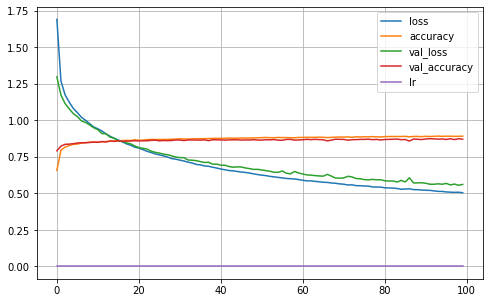

563/563 [==============================] - 1s 1ms/step
iteration: 1


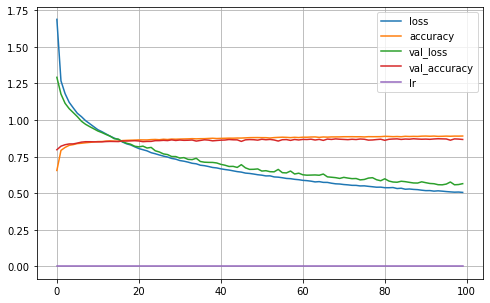

563/563 [==============================] - 1s 2ms/step
iteration: 2


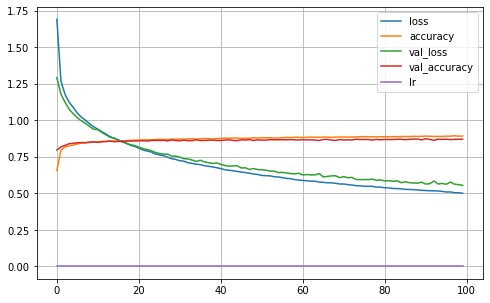

563/563 [==============================] - 1s 2ms/step
iteration: 3


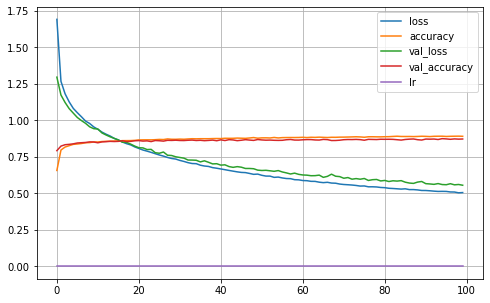

563/563 [==============================] - 1s 2ms/step
iteration: 4


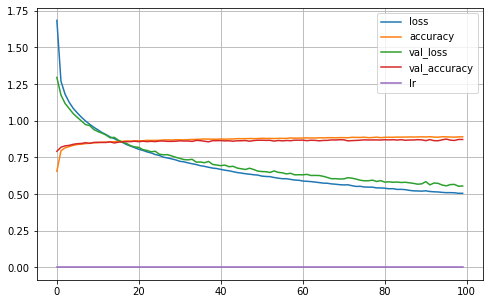

563/563 [==============================] - 1s 2ms/step
iteration: 5


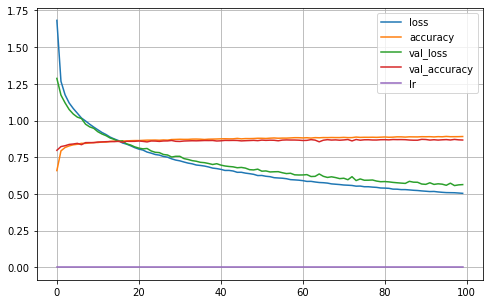

563/563 [==============================] - 1s 2ms/step
iteration: 6


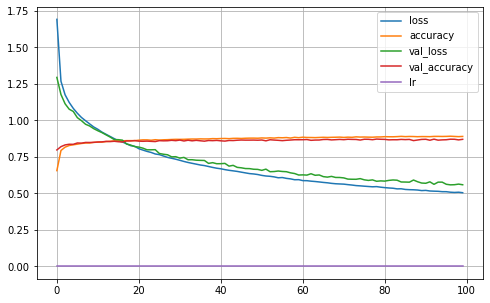

563/563 [==============================] - 1s 2ms/step
iteration: 7


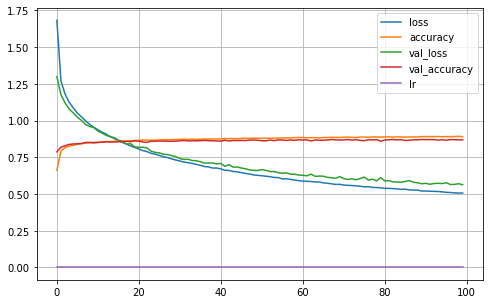

563/563 [==============================] - 1s 2ms/step
iteration: 8


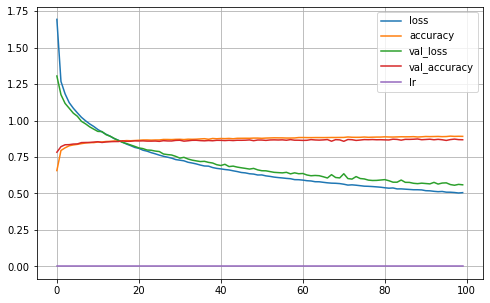

563/563 [==============================] - 1s 2ms/step
iteration: 9


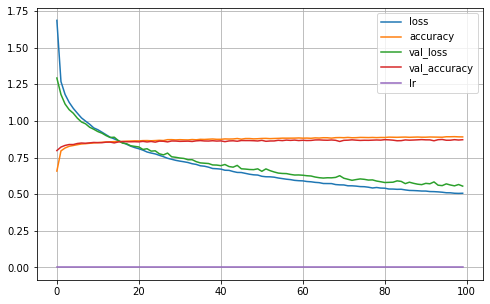

563/563 [==============================] - 1s 2ms/step


In [24]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
import pandas as pd
l1 =0.0001
NUM_RUNS =10
custom_loss = "GOLD"


results = []
for i in range(NUM_RUNS):

    print("iteration: " + str(i))
   
    MA = Keras_MA_GCCE(epochs=100,batch_size=128,R=5, K=len(np.unique(Y_true_train)), dropout=0.2, learning_rate=0.0001,optimizer='Adam', 
                l1_param=l1,  validation_split=0.30, verbose=0, q=0.1)


    MA.fit(X_train, Y_true_train)
    MA.plot_history()
  
    # Generate the predictions for the current run
    pred_2 = MA.predict(X_test)
     
    acc, auc, auc_sk,  nmi,  bacc = evaluation_metrics(Y_true_test,  pred_2, print_result=False)  # mi, ami,
    
    # Save the results for the current run to the list of dictionaries
    results.append({
        #'run': i,
        'accuracy': acc,
        'balanced_accuracy': bacc,
       # 'mutual_information': mi,
        'normalized_mutual_information': nmi,
     #   'adjusted_mutual_information': ami,
        'auc_tensorflow': auc,
        'auc_scikit_learn': auc_sk,
    })
    
# Convert the list of dictionaries to a DataFrame
df = np.round(pd.DataFrame(results)*100, 2)

# Calculate the mean and standard deviation of each metric
mean = np.round(df.mean(),2)
std = np.round(df.std(),2)  


In [25]:
df

,accuracy,balanced_accuracy,normalized_mutual_information,auc_tensorflow,auc_scikit_learn
0,86.73,85.23,77.86,88.800003,98.88
1,87.03,85.58,77.93,88.739998,98.88
2,87.24,85.79,78.14,90.839996,98.90
3,87.42,86.01,78.31,88.050003,98.90
4,87.08,85.62,77.91,87.410004,98.87
5,87.00,85.53,78.08,90.110001,98.87
6,87.23,85.78,78.24,90.040001,98.88
7,87.02,85.54,78.13,91.269997,98.87
8,86.94,85.49,77.82,85.650002,98.87
9,87.26,85.82,78.13,87.070000,98.89


In [26]:
mean

accuracy                         87.10
balanced_accuracy                85.64
normalized_mutual_information    78.06
auc_tensorflow                   88.80
auc_scikit_learn                 98.88
dtype: float64

In [27]:
std

accuracy                         0.20
balanced_accuracy                0.22
normalized_mutual_information    0.17
auc_tensorflow                   1.79
auc_scikit_learn                 0.01
dtype: float64

In [28]:
result_df = pd.concat([mean.rename('Mean'), std.rename('Std')], axis=1)

In [29]:
result_df

,Mean,Std
accuracy,87.10,0.20
balanced_accuracy,85.64,0.22
normalized_mutual_information,78.06,0.17
auc_tensorflow,88.80,1.79
auc_scikit_learn,98.88,0.01


In [30]:
# Save the DataFrame to an excel file
result_df.to_excel(database + custom_loss + ".xlsx")